# An Exact Riemann solver for 1D Euler equation

## Governing Equation
The governing equation for the Riemann problem is the Euler equations

$$ \mathbf{U}_t+\mathbf{F}(\mathbf{U})_x = 0$$

where 

$$\mathbf{U} = \left[ \begin{align}
\rho\\
\rho u\\ 
E\\ 
\end{align} 
\right]
$$, $$
\mathbf{F} = \left[ \begin{align}
\rho u\\ \rho u^2+p\\ u(E+p)\\ 
\end{align} \right] $$

with initial conditions of

$$ \mathbf{U}(x,0) = \mathbf{U}^{(0)}(x)
= \left\{ \begin{align} 
\mathbf{U}_L,\quad \text{if} \quad x<0, \\
\mathbf{U}_R,\quad \text{if} \quad x>0, \\
\end{align} \right.
$$

And the EOS is

$$ e = \frac{p}{(\gamma-1)\rho}$$.


In [1]:
struct W
    ρ::Float64
    u::Float64
    p::Float64
end

## Solving method

In the Star region, we establish a function of the pressure $p^*$ with the velocity $u^*$ on left and right sepratively.
### Left function 
$$f_L(p, \mathbf{W}_L) = \left\{ \begin{align} 
(p-p_L)\left[\frac{A_L}{p+B_L}\right]^{1/2} \quad \text{if} \quad p>p_L \quad \text(shock),\\
\frac{2a_L}{\gamma -1} \left[ \left(\frac{p}{p_L}\right)^{\frac{\gamma-1}{2\gamma}} -1\right] \quad \text{if} \quad p\le p_L \quad \text{(rarefaction)}
\end{align} \right.
$$
and the data-dependent constants $A_L, B_L, A_R,B_R$ are given by
$$ \left. \begin{array}{ll}
      A_L = \frac{2}{(\gamma+1)\rho_L},& B_L = \frac{(\gamma -1)}{(\gamma +1)}p_L,\\
      A_R = \frac{2}{(\gamma+1)\rho_R},& B_R = \frac{(\gamma -1)}{(\gamma +1)}p_R,\\
      \end{array}\right\} $$

In [2]:
function f(p::Float64,W₀::W,γ::Float64)
    ρ₀,u₀,p₀ = W₀.ρ,W₀.u,W₀.p
    
    A = 2/((γ +1 )*ρ₀)
    B = (γ-1)/(γ+1)*p₀
    
    if p>p₀ 
        return (p-p₀)*√(A/(p+B))
    else
        a₀ = √(γ*p₀/ρ₀)
        return 2a₀/(γ-1)*((p/p₀)^((γ-1)/2/γ) -1)
    end
end    

f (generic function with 1 method)

$$\rho_L^* = \rho_L(p^*/p_L)^{1/\gamma}$$
$$u^* = u_L -f_L(p^*,W_L)$$

$$\rho_R^* = \rho_R(p^*/p_R)^{1/\gamma}$$
$$u^* = u_R +f_R(p^*,W_R)$$

In [3]:
function ρₚ(p::Float64,W₀::W,γ::Float64)
    if p < W₀.p
       return W₀.ρ*(p/W₀.p)^(1/γ)
    else 
        return W₀.ρ*((γ-1)/(γ+1)+p/W₀.p)/((γ-1)/(γ+1)*p/W₀.p+1)
    end
end

ρₚ (generic function with 1 method)

In [4]:
function Derivative(f::Function,x::Float64)
    ϵ₀ = 1e-10
    if abs(x) >= ϵ₀
        ϵ= ϵ₀*x
    else
        ϵ =ϵ₀
    end
    f¹(x) = (f(x+ϵ)-f(x))/ϵ
    return f¹(x)
end

Derivative (generic function with 1 method)

In [5]:
    fₗ(p) = f(p,Wₗ,γ)
    fᵣ(p) = f(p,Wᵣ,γ)
    F(p) = fₗ(p) + fᵣ(p)+Wᵣ.u-Wₗ.u
    F¹(p) = Derivative(p->F(p),p)

F¹ (generic function with 1 method)

## Newton iteration 

We use the Newton iteration method to solve
$$f_L(p) +f_R(p)+ u_R-u_L = 0$$

In [6]:
function RiemannSolver(Wₗ::W,Wᵣ::W,γ::Float64)    
   #     γ = 1.4
     p = (Wₗ.p + Wᵣ.p)/2
     TOL = 1.0e-4
   #  i = 1
    
    ϵ = 1.0e-8
    
    WₗStar = W(ϵ,0,ϵ)
    WᵣStar = W(ϵ,0,ϵ)
    
     aₗ = √(γ*Wₗ.p/Wₗ.ρ) 
     aᵣ = √(γ*Wᵣ.p/Wᵣ.ρ) 
     cri = aₗ/(γ-1) + aᵣ/(γ-1) +Wₗ.u-Wᵣ.u
    
    if cri >0
        while true 
            F₁ = F(p)
             p1 = p- F₁/F¹(p)
             if max(abs(F₁),2*abs(p1-p)/(p1+p)) < TOL
                break
            end 
        #    i += 1
            p=max(p1,TOL)
         #   @show p,F₁  
        end

        pStar = p
        uStar = Wₗ.u-fₗ(p)
        ρₗStar = ρₚ(p,Wₗ,γ)
        ρᵣStar = ρₚ(p,Wᵣ,γ)
        WₗStar = W(ρₗStar,uStar,pStar)
        WᵣStar = W(ρᵣStar,uStar,pStar)
    end
    
    return WₗStar,WᵣStar
end

RiemannSolver (generic function with 1 method)

### A complete result
After Solving the states in the star regions, if we want to get a detailed ditribution, we can use the following function.


In [7]:
function SolveDistr(t::Float64,Wₗ::W,Wᵣ::W,γ::Float64)
    
    WₗStar,WᵣStar = RiemannSolver(Wₗ,Wᵣ,γ)
    
    ρₗStar,uStar, pStar =WₗStar.ρ,WₗStar.u,WₗStar.p
    ρᵣStar = WᵣStar.ρ
    ρₗ,pₗ,uₗ = Wₗ.ρ,Wₗ.p,Wₗ.u
    ρᵣ,pᵣ,uᵣ = Wᵣ.ρ,Wᵣ.p,Wᵣ.u
    
    I = 1200
    U = zeros(Float64,(I,3))
    x = zeros(Float64,I)
    if pStar > pₗ  # Left shock
        sL = (ρₗStar*uStar - ρₗ*uₗ)/(ρₗStar-ρₗ)
        for i =1:200
            x[i] = (2-0.005*(i-1))*sL*t
            U[i,:] = [ρₗ,uₗ,pₗ]
        end
        for i = 201:600
            x[i] = ((uStar-sL)/400*(i-200) + sL)*t
            U[i,:] = [ρₗStar,uStar,pStar]
        end
    else  # Left Rarefaction
        cL = √(γ*pₗ/ρₗ)
        cLStar = √(γ*pStar/ρₗStar)
        sLSlow = uₗ - cL
        sLFast = uStar - cLStar
        for i = 1:200
            x[i] =(2-0.005*(i-1))*sLSlow*t
            U[i,:] = [ρₗ,uₗ,pₗ]
        end
        
        x[201:400],U[201:400,:] = RareSpeedToU(t,Wₗ,pStar,γ,1)
        for i =401:600
            x[i] = ((uStar - sLFast)/200*(i-400) + sLFast)*t 
            U[i,:] = [ρₗStar,uStar,pStar]
        end 
    end
    
    if pStar > pᵣ  # Right shock
        sR = (ρᵣStar*uStar - ρᵣ*uᵣ)/(ρᵣStar-ρᵣ)
      #  @show ρᵣStar, ρᵣ
        for i =601:1000
            x[i] = ((-uStar+sR)/400*(i-600) + uStar)*t
            U[i,:] = [ρᵣStar,uStar,pStar]
        end
        for i = 1001:1200
            x[i] = (1+0.005*(i-1001))*sR*t
            U[i,:] = [ρᵣ,uᵣ,pᵣ]
        end
    else  # Right Rarefaction
        cR = √(γ*pᵣ/ρᵣ)
        cRStar = √(γ*pStar/ρᵣStar)
        sRFast = uᵣ + cR
        sRSlow = uStar + cRStar
        
        for i = 1000:1200
           x[i] =(1+0.005*(i-1001))*sRFast*t
            U[i,:] = [ρᵣ,uᵣ,pᵣ]
        end
        
        x[801:1000],U[801:1000,:] = RareSpeedToU(t,Wᵣ,pStar,γ,2)
        for i =601:800
             x[i] = ((-uStar + sRSlow)/200*(i-600) + uStar)*t 
             U[i,:] = [ρᵣStar,uStar,pStar]
        end 
    end
    return x, U
end

SolveDistr (generic function with 1 method)

In [8]:
function RareSpeedToU(t::Float64, W₀::W, p::Float64,γ::Float64,LoR::Int)
    ρ₀,u₀,p₀ = W₀.ρ, W₀.u,W₀.p
    
    x = zeros(Float64,200)
    U = zeros(Float64,(200,3))
    
    Δp = (p-p₀)/200
    
    for i in 1:200
        p = p₀ + Δp*(i-1)
        ρ = ρₚ(p, W₀, γ)
        c= √(γ*p/ρ)
        f₀ = f(p, W₀, γ)
        if LoR == 1
            u = u₀-f₀
            uc = u-c
        x[i] = uc*t
        U[i,1:3] = [ρ,u,p]
        else
            u = u₀+f₀
            uc = u+c
        x[200-i+1] = uc*t
        U[200-i+1,1:3] = [ρ,u,p]
        end
        
    end
    return x, U            
end

RareSpeedToU (generic function with 1 method)

In [11]:
Wₗ = W(1.0,0.0,1.0)
Wᵣ = W(0.125,0.0,0.1)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

([-0.236643, -0.236052, -0.23546, -0.234868, -0.234277, -0.233685, -0.233094, -0.232502, -0.23191, -0.231319  …  0.34167, 0.342546, 0.343423, 0.344299, 0.345175, 0.346051, 0.346927, 0.347803, 0.348679, 0.349555], [1.0 0.0 1.0; 1.0 0.0 1.0; … ; 0.125 0.0 0.1; 0.125 0.0 0.1])

In [11]:
using Plots
using LaTeXStrings
pyplot()

Plots.PyPlotBackend()

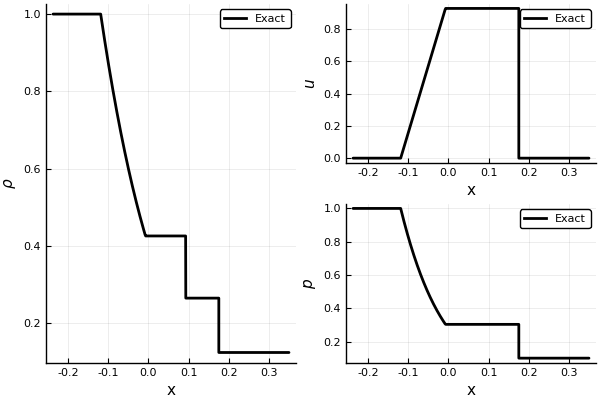

In [12]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)

In [13]:
Wₗ = W(1.0,0.0,1000)
Wᵣ = W(1.0,0.0,0.01)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

([-7.48331, -7.46461, -7.4459, -7.42719, -7.40848, -7.38977, -7.37107, -7.35236, -7.33365, -7.31494  …  4.58593, 4.59769, 4.60945, 4.62121, 4.63297, 4.64473, 4.65649, 4.66825, 4.68, 4.69176], [1.0 0.0 1000.0; 1.0 0.0 1000.0; … ; 1.0 0.0 0.01; 1.0 0.0 0.01])

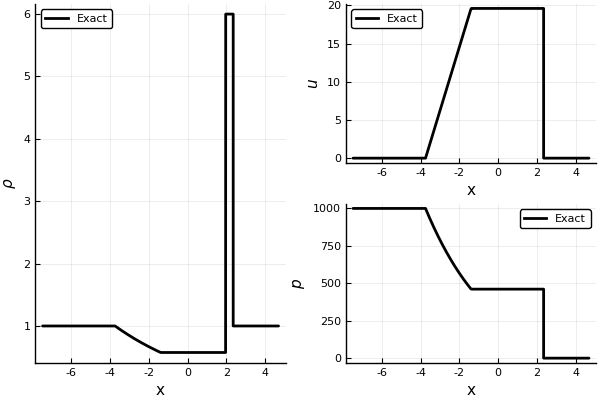

In [14]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)

In [15]:
Wₗ = W(1.0,0.0,0.01)
Wᵣ = W(1.0,0.0,100)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

([-1.48749, -1.48377, -1.48006, -1.47634, -1.47262, -1.4689, -1.46518, -1.46146, -1.45774, -1.45402  …  2.30727, 2.31319, 2.3191, 2.32502, 2.33094, 2.33685, 2.34277, 2.34868, 2.3546, 2.36052], [1.0 0.0 0.01; 1.0 0.0 0.01; … ; 1.0 0.0 100.0; 1.0 0.0 100.0])

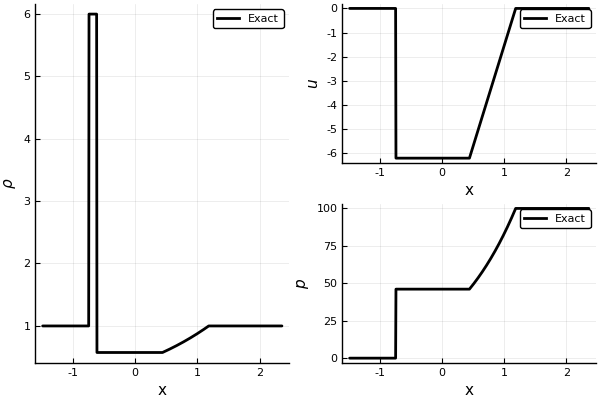

In [15]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)

In [1]:
Wₗ = W(1.0,0.0,0.01)
Wᵣ = W(1.0,1.0,0.01)
γ = 1.4
#RiemannSolver(Wₗ,Wᵣ,γ)
x,U = SolveDistr(0.1,Wₗ,Wᵣ,γ)

UndefVarError: UndefVarError: W not defined

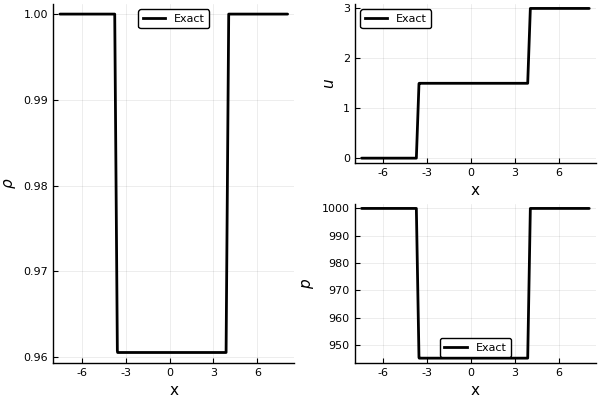

In [16]:
p1 = plot(x,U[:,1], xlabel = "x", ylabel=L" \rho",width =2 ,label = "Exact",color ="black")
p2 = plot(x,U[:,2], xlabel = "x", ylabel=L" u",width =2 ,label = "Exact",color ="black")
p3 = plot(x,U[:,3], xlabel = "x", ylabel=L" p",width =2 ,label = "Exact",color ="black")
l=@layout [a [b;c]]
p = plot(p1,p2,p3,layout=l)

# Training set

In [120]:
using BenchmarkTools

In [9]:
N = 10^4

X1 = zeros(Float32, (3,N))
for i in 1:N    
  #  pL = 10 .^ (rand() .*4 .- 2)   #  0.01 -> 1000
    ρR = 10 .^ (rand() .*3 .- 2)   # 0.01 -> 100
    uR = rand() .* 23 .- 20        # -20 -> 3
    pR = 10 .^ (rand() .*5 .- 2)   
    X1[1:3,i ] = [ρR,uR,pR]
end

In [10]:
Y1 = zeros(Float32, (4,N))
γ = 1.4
Wₗ = W(1.0,1.0,1.0)
Wᵣ = W(1.0,1.0,1.0)
for i = 1:N
#i = 1
    Wₗ = W(1.0,0.0,1.0)
    Wᵣ = W(X1[1,i],X1[2,i],X1[3,i])
    WₗStar,WᵣStar = RiemannSolver(Wₗ,Wᵣ,γ)
    Y1[1,i] = WₗStar.ρ
    Y1[2,i] = WᵣStar.ρ
    Y1[3,i] =WₗStar.u
    Y1[4,i] =WₗStar.p 
end

In [11]:
X = X1
Y = Y1

4×10000 Array{Float32,2}:
  5.60186   4.40562      5.79803  …    5.71263    4.38652     4.23963
 11.7965    0.0214085   10.9838        0.476481   0.0172932   7.88627
 -8.15267  -3.39975    -11.7309       -9.73135   -3.36792    -3.13746
 81.9094   15.9522     167.294       115.794     15.6923     13.8822 

In [12]:
using BSON:@save,@load
@save  "DATA.bson" X Y

In [13]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated
using CuArrays

In [14]:
X = X |> gpu
Y = Y |> gpu

4×10000 CuArray{Float32,2}:
  5.60186   4.40562      5.79803  …    5.71263    4.38652     4.23963
 11.7965    0.0214085   10.9838        0.476481   0.0172932   7.88627
 -8.15267  -3.39975    -11.7309       -9.73135   -3.36792    -3.13746
 81.9094   15.9522     167.294       115.794     15.6923     13.8822 

### model

In [144]:
#  m = Chain(
#     Dense(3, 32,σ),
#  #   Dense(16, 32,σ),
#     Dense(32, 72,σ),
#  #   Dense(36, 36,σ),
# #    Dense( 18,36,σ),
#    # Dense( 32,32,σ),
#    #  Dense( 64,64,σ),
# #    Dense( 36,18,σ),
#  #   Dense( 72,16,σ),
#  #  Dropout(0.5),
#     Dense(72,4)
#     ) |> gpu
    

Chain(Dense(3, 32, NNlib.σ), Dense(32, 72, NNlib.σ), Dense(72, 4))

### Loss function

In [15]:
loss(x,y) = sum(abs2,(m(x)-y))/N

loss (generic function with 1 method)

In [16]:
data = Iterators.repeated((X,Y),1000000000)

Base.Iterators.Take{Base.Iterators.Repeated{Tuple{CuArray{Float32,2},CuArray{Float32,2}}}}(Base.Iterators.Repeated{Tuple{CuArray{Float32,2},CuArray{Float32,2}}}((Float32[3.60328 0.013518 … 0.0131746 1.9727; -11.8241 -17.8572 … -12.8697 -5.33228; 11.9778 8.28602 … 10.698 1.20925], Float32[5.60186 4.40562 … 4.38652 4.23963; 11.7965 0.0214085 … 0.0172932 7.88627; -8.15267 -3.39975 … -3.36792 -3.13746; 81.9094 15.9522 … 15.6923 13.8822])), 1000000000)

### Optomizer

In [17]:
opt = ADAM()
#opt = ADADelta()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [18]:
evalcb = () -> @show(loss(X, Y))

#6 (generic function with 1 method)

In [ ]:
Flux.train!(loss, Flux.params(m), data, opt, cb = throttle(evalcb, 10))

loss(X, Y) = 414.1908f0 (tracked)
loss(X, Y) = 0.59248954f0 (tracked)
loss(X, Y) = 0.5190531f0 (tracked)
loss(X, Y) = 0.47846153f0 (tracked)
loss(X, Y) = 0.4440053f0 (tracked)
loss(X, Y) = 0.45769286f0 (tracked)
loss(X, Y) = 0.3964314f0 (tracked)
loss(X, Y) = 0.75832886f0 (tracked)
loss(X, Y) = 0.37352473f0 (tracked)
loss(X, Y) = 0.35138726f0 (tracked)
loss(X, Y) = 0.34058967f0 (tracked)
loss(X, Y) = 1.2640657f0 (tracked)
loss(X, Y) = 0.320592f0 (tracked)
loss(X, Y) = 0.3124482f0 (tracked)
loss(X, Y) = 0.3279043f0 (tracked)
loss(X, Y) = 0.30064663f0 (tracked)
loss(X, Y) = 0.29111958f0 (tracked)
loss(X, Y) = 0.28740874f0 (tracked)
loss(X, Y) = 0.28025758f0 (tracked)
loss(X, Y) = 0.28197291f0 (tracked)
loss(X, Y) = 0.26861095f0 (tracked)
loss(X, Y) = 0.26617885f0 (tracked)
loss(X, Y) = 0.3177484f0 (tracked)
loss(X, Y) = 0.25918764f0 (tracked)
loss(X, Y) = 0.25585997f0 (tracked)
loss(X, Y) = 0.25024274f0 (tracked)
loss(X, Y) = 0.5377996f0 (tracked)
loss(X, Y) = 0.48156178f0 (tracked)
loss

loss(X, Y) = 0.10722699f0 (tracked)
loss(X, Y) = 0.1068271f0 (tracked)
loss(X, Y) = 0.10689208f0 (tracked)
loss(X, Y) = 0.1066724f0 (tracked)
loss(X, Y) = 0.10649499f0 (tracked)
loss(X, Y) = 0.10618649f0 (tracked)
loss(X, Y) = 0.11394522f0 (tracked)
loss(X, Y) = 0.16498232f0 (tracked)
loss(X, Y) = 0.107630186f0 (tracked)
loss(X, Y) = 0.10547525f0 (tracked)
loss(X, Y) = 0.11211122f0 (tracked)
loss(X, Y) = 4.3297095f0 (tracked)
loss(X, Y) = 0.10541081f0 (tracked)
loss(X, Y) = 2.4692013f0 (tracked)
loss(X, Y) = 0.10490452f0 (tracked)
loss(X, Y) = 0.13236803f0 (tracked)
loss(X, Y) = 0.46703917f0 (tracked)
loss(X, Y) = 0.1043326f0 (tracked)
loss(X, Y) = 0.10427057f0 (tracked)
loss(X, Y) = 0.10394691f0 (tracked)
loss(X, Y) = 0.10415537f0 (tracked)
loss(X, Y) = 0.103815965f0 (tracked)
loss(X, Y) = 0.10360408f0 (tracked)
loss(X, Y) = 0.10368049f0 (tracked)
loss(X, Y) = 1.8914979f0 (tracked)
loss(X, Y) = 0.10316689f0 (tracked)
loss(X, Y) = 0.10352229f0 (tracked)
loss(X, Y) = 0.103326395f0 (trac

loss(X, Y) = 0.08467019f0 (tracked)
loss(X, Y) = 0.084280655f0 (tracked)
loss(X, Y) = 0.08469846f0 (tracked)
loss(X, Y) = 0.0842105f0 (tracked)
loss(X, Y) = 0.7705177f0 (tracked)
loss(X, Y) = 0.08430539f0 (tracked)
loss(X, Y) = 0.6053326f0 (tracked)
loss(X, Y) = 0.08399494f0 (tracked)
loss(X, Y) = 0.085031025f0 (tracked)
loss(X, Y) = 0.084154576f0 (tracked)
loss(X, Y) = 0.08381401f0 (tracked)
loss(X, Y) = 0.08429761f0 (tracked)
loss(X, Y) = 0.08361441f0 (tracked)
loss(X, Y) = 1.0186903f0 (tracked)
loss(X, Y) = 0.083810784f0 (tracked)
loss(X, Y) = 0.083505504f0 (tracked)
loss(X, Y) = 0.14229885f0 (tracked)
loss(X, Y) = 0.084264934f0 (tracked)
loss(X, Y) = 0.0833651f0 (tracked)
loss(X, Y) = 0.25081122f0 (tracked)
loss(X, Y) = 0.08359258f0 (tracked)
loss(X, Y) = 0.08323401f0 (tracked)
loss(X, Y) = 0.45729107f0 (tracked)
loss(X, Y) = 0.08497525f0 (tracked)
loss(X, Y) = 0.08358576f0 (tracked)
loss(X, Y) = 0.0832993f0 (tracked)
loss(X, Y) = 0.08298234f0 (tracked)
loss(X, Y) = 0.431887f0 (tra

In [21]:
m = m |> gpu

Chain(Dense(3, 32, NNlib.σ), Dense(32, 72, NNlib.σ), Dense(72, 4))

In [20]:
@load "model3_4.bson" m

In [230]:
#@save "model3_4.bson" m

In [150]:
  pL = 1   #  0.01 -> 100
    ρR = 10 .^ (rand() .*3 .- 2)   # 0.01 -> 10
    uR = rand() .* 23 .- 20        # -20 -> 3
    pR = 10 .^ (rand() .*4 .- 2) 

# pL = 10 .^ (rand() .*5 .- 2)   #  0.01 -> 1000
# ρR = 10 .^ (rand() .*4 .- 2)   # 0.01 -> 10
# uR = rand() .* 22 .- 20        # -20 -> 3
# pR = 10 .^ (rand() .*5 .- 2) 

A  = [ρR; uR; pR]

3-element Array{Float64,1}:
  1.275491276680905 
 -7.19724811765138  
  2.4182635555217975

In [151]:
using BenchmarkTools
@btime m(A)

  2.399 μs (68 allocations: 3.02 KiB)


Tracked 4-element Array{Float32,1}:
  4.720478f0 
  4.6437087f0
 -3.9273477f0
 20.558842f0 

In [220]:
 m(A)

Tracked 4-element Array{Float32,1}:
  4.724888f0 
  4.686824f0 
 -3.9744406f0
 20.760496f0 

In [152]:
Wₗ = W(1.0, 0.0, 1.0)
Wᵣ = W(ρR,uR,pR)
γ = 1.4
@btime WLStar, WRStar = RiemannSolver(Wₗ,Wᵣ,γ)


# 5.99
# 67.16
# -9.92
# 118.33

  2.845 μs (193 allocations: 3.02 KiB)


(W(4.699530121973835, -3.9592982711879317, 20.913349237371392), W(4.605300537057218, -3.9592982711879317, 20.913349237371392))

In [282]:
4.7342587f0
  4.5680723f0
 -3.9600163f0
 20.905327f0 

-0.16666666666666669

#  Error Test

In [552]:
X_test = zeros(Float32, (4,1000))
Y_test = zeros(Float32, (4,1000))
for i in 1:1000    
    pL = 10 .^ (rand() .*5 .- 2)   #  0.01 -> 1000
    ρR = 10 .^ (rand() .*4 .- 2)   # 0.01 -> 10
    uR = rand() .* 22 .- 20        # -20 -> 3
    pR = 10 .^ (rand() .*5 .- 2)   
    X_test[1:4,i ] = [pL,ρR,uR,pR]
end

In [553]:
#function 
Y_test = zeros(Float32, (4,1000))
γ = 1.4
Wₗ = W(1.0,1.0,1.0)
Wᵣ = W(1.0,1.0,1.0)
for i = 1:1000
#i = 1
    Wₗ = W(1.0,0.0,X[1,i])
    Wᵣ = W(X[2,i],X[3,i],X[4,i])
    WₗStar,WᵣStar = RiemannSolver(Wₗ,Wᵣ,γ)
    Y_test[1,i] = WₗStar.ρ
    Y_test[2,i] = WᵣStar.ρ
    Y_test[3,i] =WₗStar.u
    Y_test[4,i] =WₗStar.p
end